
<div style="color:white; background-color:purple; width:100%; padding:20px; box-sizing:border-box; margin:0;">
  <h2> Title: MSDS458_Final_Project</h2>
  <h4> Student: Pedro Perez Alvarez</h4>
</div>



## Description:


This project explores the effectiveness of transformer-based deep learning architectures for sentiment analysis in the context of restaurant reviews.

In [ ]:
!pip install -q numpy==1.26.4 scipy==1.12.0 gensim==4.3.0

In [ ]:
!pip install -U tf_keras
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
# Cell 2 – force Colab to restart the *kernel* itself
import os, signal, sys
os.kill(os.getpid(), signal.SIGTERM)
# Session will "crash" here

In [ ]:
# Cell 3: Verify installation and import all libraries
# After the automatic restart, this will be the first cell to run

# In Google Colab, select Runtime > Run cell and below
import numpy as np, gensim
print("NumPy :", np.__version__)     # 1.26.4
print("Gensim:", gensim.__version__) # 4.3.0

NumPy : 1.26.4
Gensim: 4.3.0


In [ ]:
# import os
# os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k
from transformers import TFBertForSequenceClassification
from transformers import BertTokenizer
from tensorflow.keras.optimizers import Adam


from typing import List, Callable, Dict, Tuple, Set

from transformers import pipeline

# import tensorflow
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification
)
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import inspect

print("TF version:", tf.__version__)                              # should be 2.18.0
print("Adam module:", inspect.getmodule(Adam).__name__)  # should be tensorflow.python.keras.optimizers.adam


TF version: 2.19.0
Adam module: keras.src.optimizers.adam


## Requires Restart Of Runtime After Installation

### Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# # Base path in Google Drive
# base_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/'

# # Load JSON datasets
# def load_yelp_json(file_path): # Changed parameter name for clarity
#     return pd.read_json(file_path, lines=True)

# # Load the 3 relevant datasets using the full path
# review_df = load_yelp_json(base_path + "review.json")
# user_df = load_yelp_json(base_path + "user.json")
# business_df = load_yelp_json(base_path + "business.json")

# # Join review with user on user_id
# review_user_df = pd.merge(review_df, user_df, on="user_id", suffixes=('', '_user'))

# # Join the result with business on business_id
# full_df = pd.merge(review_user_df, business_df, on="business_id", suffixes=('', '_business'))

# # Preview the shape and sample
# print("Combined dataset shape:", full_df.shape)
# print(full_df[['review_id', 'name', 'city', 'stars', 'text']].sample(5))

Combined dataset shape: (6990247, 43)
                      review_id      name              city  stars  \
561004   0g49T7uA9jW2YQbvyTAplA    J Ryan  Saint Petersburg      5   
4462119  hTROg7k1goJlYRx6-gFugQ    Tucson            Tucson      1   
3538978  KpuslFxBCHdGZ2zjNxXC_g  Rachelle       Saint Louis      5   
6380610  LM7VLS7tDhUkUllmgU5P2w    Tucker      Philadelphia      5   
3999250  f_iPCtuEnp7bkOWlhfC0jg       Tom              Reno      4   

                                                      text  
561004   Cant say enough about this place.  Great (AMAZ...  
4462119  Have eaten there three times. During the first...  
3538978  Went for my bday and was treated like royalty!...  
6380610  Great burrito's, chicken is definitely my favo...  
3999250  I'm just traveling through but it looks brand ...  


In [ ]:
# # Create the 'sentiment' column based on 'stars'
# full_df['sentiment'] = np.where(full_df['stars'] >= 4, 'positive', 'negative')

# # 2. Separate positive and negative reviews
# positive_reviews = full_df[full_df['sentiment'] == 'positive']
# negative_reviews = full_df[full_df['sentiment'] == 'negative']

# # 3. Check if enough records are available for sampling
# num_positive_to_sample = 30000
# num_negative_to_sample = 30000

# print(f"Available positive reviews: {len(positive_reviews)}")
# print(f"Available negative reviews: {len(negative_reviews)}")

# can_sample_positive = len(positive_reviews) >= num_positive_to_sample
# can_sample_negative = len(negative_reviews) >= num_negative_to_sample

# sampled_df_list = []

# if can_sample_positive:
#     positive_sample = positive_reviews.sample(n=num_positive_to_sample, random_state=42) # random_state for reproducibility
#     sampled_df_list.append(positive_sample)
#     print(f"Sampled {len(positive_sample)} positive reviews.")
# else:
#     print(f"Warning: Not enough positive reviews to sample {num_positive_to_sample}. Available: {len(positive_reviews)}. Sampling all available positive reviews.")
#     if len(positive_reviews) > 0:
#          sampled_df_list.append(positive_reviews.copy()) # Sample all available

# if can_sample_negative:
#     negative_sample = negative_reviews.sample(n=num_negative_to_sample, random_state=42) # random_state for reproducibility
#     sampled_df_list.append(negative_sample)
#     print(f"Sampled {len(negative_sample)} negative reviews.")
# else:
#     print(f"Warning: Not enough negative reviews to sample {num_negative_to_sample}. Available: {len(negative_reviews)}. Sampling all available negative reviews.")
#     if len(negative_reviews) > 0:
#         sampled_df_list.append(negative_reviews.copy()) # Sample all available

# # 4. Combine the samples
# if sampled_df_list:
#     balanced_sample_df = pd.concat(sampled_df_list)
#     # Shuffle the combined DataFrame
#     balanced_sample_df = balanced_sample_df.sample(frac=1, random_state=42).reset_index(drop=True)
#     print(f"\nTotal records in the balanced sample: {len(balanced_sample_df)}")
#     print("Sentiment distribution in the sample:")
#     print(balanced_sample_df['sentiment'].value_counts())
#     print("\nFirst 5 rows of the balanced sample:")
#     print(balanced_sample_df.head())
# else:
#     print("\nNo data to sample or combine.")



Available positive reviews: 4684523
Available negative reviews: 2305724
Sampled 30000 positive reviews.
Sampled 30000 negative reviews.

Total records in the balanced sample: 60000
Sentiment distribution in the sample:
sentiment
positive    30000
negative    30000
Name: count, dtype: int64

First 5 rows of the balanced sample:
                review_id                 user_id             business_id  \
0  sMSUZvYnuneKXArrQaECkg  C4CjBJLrQFD79hFofN7Dug  Ix-NE3bXbn_rKCTbNM2HEw   
1  4chBfLDJdzNkqqO5xLUYYw  RGO7_81aYXGvgTp8Ta6sXw  kbXpjBSweedxQ1WrlJ5i7Q   
2  k2wPT0BpkUxvEUoWrVS-Eg  euGYfQtGCC9_illkgaeJ5A  36rz3AMPh8ETMJq7cTG2Rw   
3  SGHW0pRwQtxnMzBFbwHwag  v5_c1QBPn2w-xnzbjoZ4GQ  -gikv6T4uE5GvpZ7iQx-Pw   
4  2Dfsw1N5rtivqPSCJ3O5Aw  xSbR1WLwRpPpdTlNrtAmcg  Jzb2IQSwPfULWzdl9Bq5fg   

   stars  useful  funny  cool  \
0      5       0      0     0   
1      2       0      0     0   
2      1       6      1     0   
3      5       0      0     0   
4      5       0      0     0   

         

In [ ]:
# output_filename_balanced_sample = base_path + 'balanced_sentiment_sample_60k.csv'

# try:
#     if 'balanced_sample_df' in locals() or 'balanced_sample_df' in globals():
#         balanced_sample_df.to_csv(output_filename_balanced_sample, index=False)
#         print(f"Balanced sample DataFrame saved successfully to: {output_filename_balanced_sample}")
#     else:
#         print("Error: The DataFrame 'balanced_sample_df' does not exist. Please ensure it was created correctly in the previous steps.")

# except NameError:
#     print("Error: The 'base_path' variable is not defined. Please define it with the correct path to your Google Drive directory.")
# except Exception as e:
#     print(f"An error occurred while saving the CSV: {e}")

Balanced sample DataFrame saved successfully to: /content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/balanced_sentiment_sample_60k.csv


In [ ]:
balanced_sample_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/balanced_sentiment_sample_60k.csv")

## Exploratory Data Analysis

In [ ]:


if 'balanced_sample_df' in locals() or 'balanced_sample_df' in globals():
    if len(balanced_sample_df) >= 1000:
        df = balanced_sample_df.head(1000).copy()
        print("Using the first 1000 rows from 'balanced_sample_df'.")
    else:
        df = balanced_sample_df.copy()
        print(f"Warning: 'balanced_sample_df' has less than 1000 rows. Using the full DataFrame with {len(df)} rows.")

    # Display the first few rows
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())
    print("\n" + "="*50 + "\n")

    # Display DataFrame information (data types, non-null counts)
    print("DataFrame Information:")
    df.info()
    print("\n" + "="*50 + "\n")

    # Display descriptive statistics for numerical columns
    print("Descriptive Statistics for numerical columns:")
    print(df.describe())
    print("\n" + "="*50 + "\n")

    # Check for missing values
    print("Missing values in each column:")
    print(df.isnull().sum())
    print("\n" + "="*50 + "\n")

    print("Columns available:")
    print(df.columns)
else:
    print("Error: DataFrame 'balanced_sample_df' not found. Please ensure it is loaded.")

Using the first 1000 rows from 'balanced_sample_df'.

First 5 rows of the DataFrame:
                review_id                 user_id             business_id  \
0  sMSUZvYnuneKXArrQaECkg  C4CjBJLrQFD79hFofN7Dug  Ix-NE3bXbn_rKCTbNM2HEw   
1  4chBfLDJdzNkqqO5xLUYYw  RGO7_81aYXGvgTp8Ta6sXw  kbXpjBSweedxQ1WrlJ5i7Q   
2  k2wPT0BpkUxvEUoWrVS-Eg  euGYfQtGCC9_illkgaeJ5A  36rz3AMPh8ETMJq7cTG2Rw   
3  SGHW0pRwQtxnMzBFbwHwag  v5_c1QBPn2w-xnzbjoZ4GQ  -gikv6T4uE5GvpZ7iQx-Pw   
4  2Dfsw1N5rtivqPSCJ3O5Aw  xSbR1WLwRpPpdTlNrtAmcg  Jzb2IQSwPfULWzdl9Bq5fg   

   stars  useful  funny  cool  \
0      5       0      0     0   
1      2       0      0     0   
2      1       6      1     0   
3      5       0      0     0   
4      5       0      0     0   

                                                text                 date  \
0  One of our favorite pizza places in the area, ...  2021-03-26 21:45:37   
1  It's not that I disliked this place it just ki...  2015-10-26 16:00:05   
2  Hate to give bad re

Value counts for 'sentiment':
sentiment
negative    509
positive    491
Name: count, dtype: int64




<ipython-input-10-1dcb5b4ad64d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette={'positive': 'green', 'negative': 'red'}, order=df['sentiment'].value_counts().index)


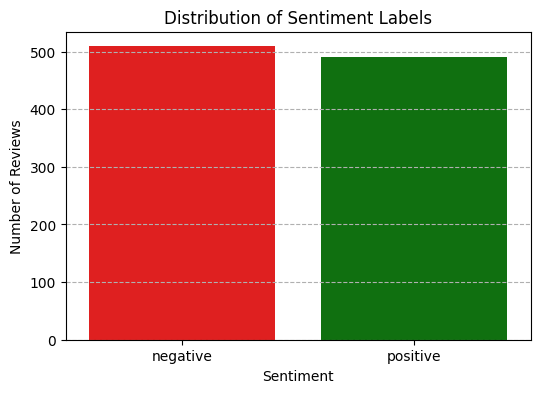



Value counts for 'stars':
stars
1    228
2    126
3    155
4    151
5    340
Name: count, dtype: int64




<ipython-input-10-1dcb5b4ad64d>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df, palette='viridis', order=sorted(df['stars'].unique()))


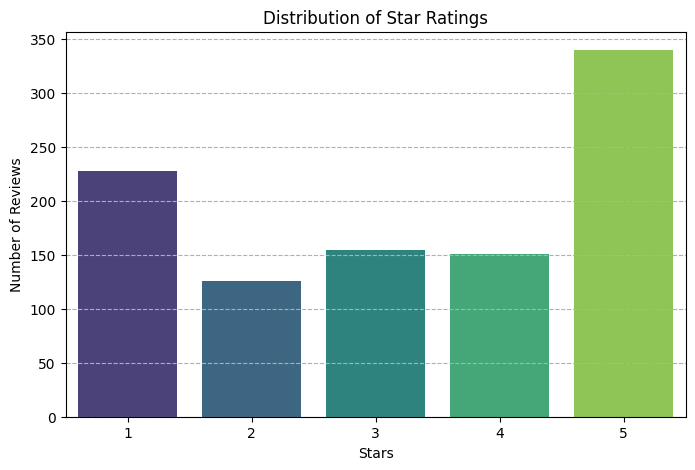



Crosstab of Stars vs Sentiment:
sentiment  negative  positive
stars                        
1               228         0
2               126         0
3               155         0
4                 0       151
5                 0       340




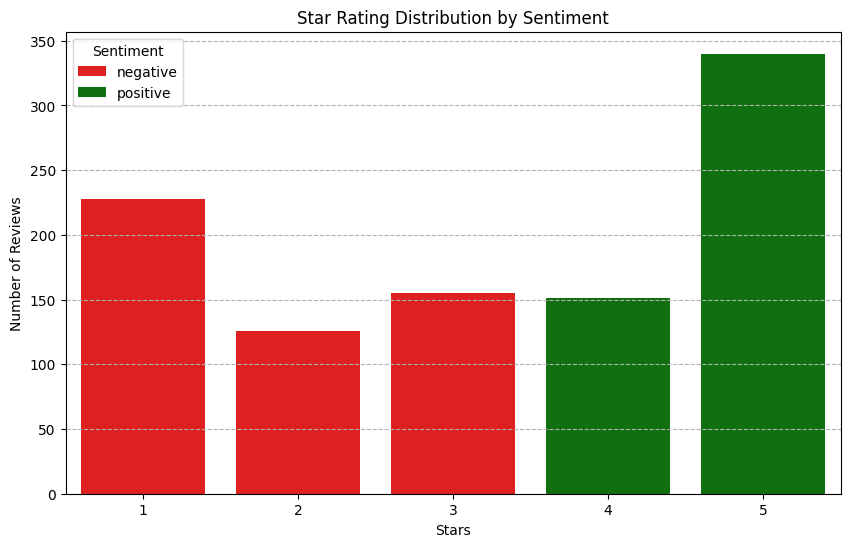

In [ ]:
if 'df' in locals() or 'df' in globals():
    if 'sentiment' in df.columns:
        print("Value counts for 'sentiment':")
        print(df['sentiment'].value_counts())
        print("\n" + "="*50 + "\n")

        # Plot distribution of sentiment
        plt.figure(figsize=(6, 4))
        sns.countplot(x='sentiment', data=df, palette={'positive': 'green', 'negative': 'red'}, order=df['sentiment'].value_counts().index)
        plt.title('Distribution of Sentiment Labels')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Reviews')
        plt.grid(axis='y', linestyle='--')
        plt.show()
    else:
        print("'sentiment' column not found in the DataFrame 'df'.")

    print("\n" + "="*50 + "\n")

    if 'stars' in df.columns:
        print("Value counts for 'stars':")
        print(df['stars'].value_counts().sort_index())
        print("\n" + "="*50 + "\n")

        # Plot distribution of stars
        plt.figure(figsize=(8, 5))
        sns.countplot(x='stars', data=df, palette='viridis', order=sorted(df['stars'].unique()))
        plt.title('Distribution of Star Ratings')
        plt.xlabel('Stars')
        plt.ylabel('Number of Reviews')
        plt.grid(axis='y', linestyle='--')
        plt.show()
        print("\n" + "="*50 + "\n")

        # Relationship between 'stars' and 'sentiment'
        if 'sentiment' in df.columns:
            print("Crosstab of Stars vs Sentiment:")
            print(pd.crosstab(df['stars'], df['sentiment']))
            print("\n" + "="*50 + "\n")

            plt.figure(figsize=(10, 6))
            sns.countplot(x='stars', hue='sentiment', data=df, palette={'positive': 'green', 'negative': 'red'})
            plt.title('Star Rating Distribution by Sentiment')
            plt.xlabel('Stars')
            plt.ylabel('Number of Reviews')
            plt.legend(title='Sentiment')
            plt.grid(axis='y', linestyle='--')
            plt.show()
        else:
            print("'sentiment' column not found to analyze relationship with 'stars'.")
    else:
        print("'stars' column not found in the DataFrame 'df'.")
else:
    print("Error: DataFrame 'df' not found. Please ensure Updated EDA Block 1 was executed successfully.")

Descriptive statistics for review length (characters):
count    1000.000000
mean      602.249000
std       553.023839
min        44.000000
25%       239.000000
50%       421.500000
75%       766.500000
max      3979.000000
Name: review_length_chars, dtype: float64


Descriptive statistics for review length (words):
count    1000.000000
mean      111.593000
std       103.316648
min         9.000000
25%        44.000000
50%        79.000000
75%       143.000000
max       790.000000
Name: review_length_words, dtype: float64




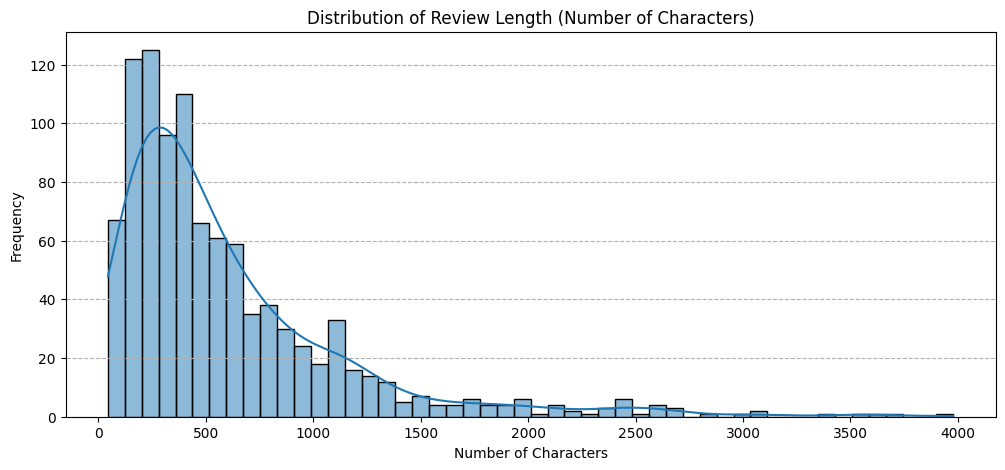

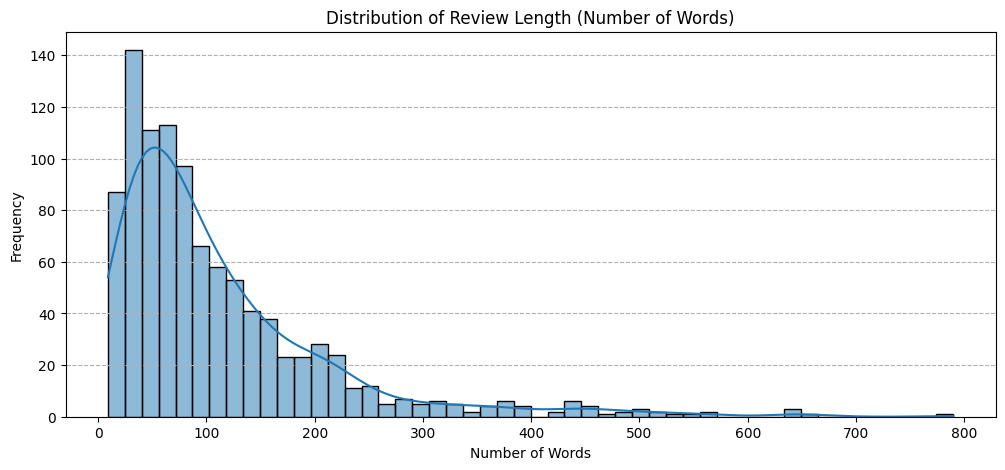

<ipython-input-12-3b79c878367b>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length_chars', data=df, palette={'positive': 'green', 'negative': 'red'})


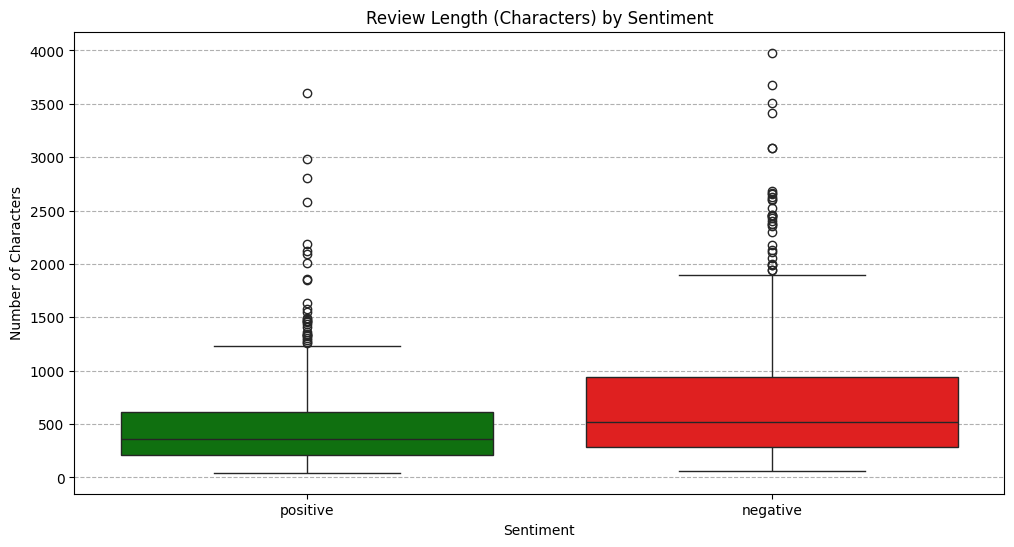

<ipython-input-12-3b79c878367b>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length_words', data=df, palette={'positive': 'green', 'negative': 'red'})


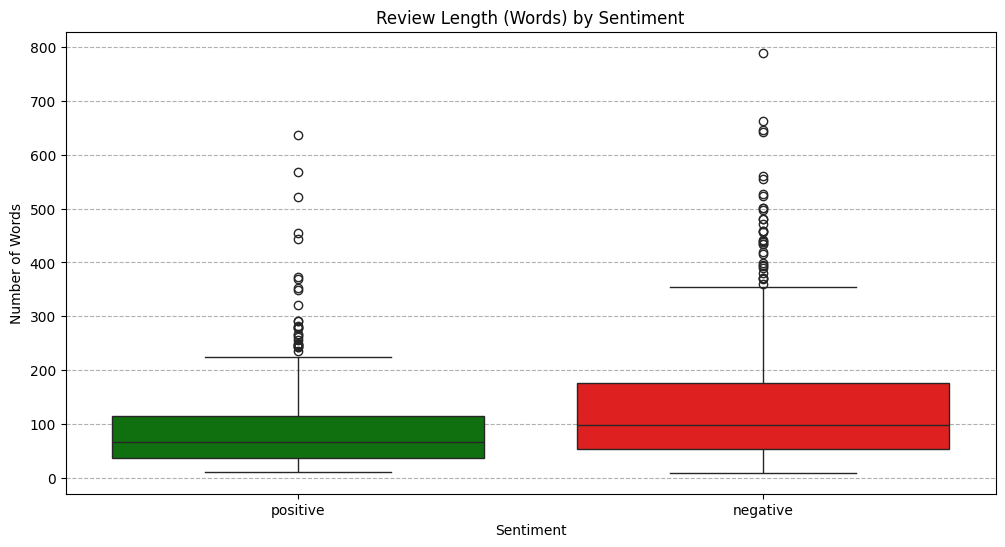

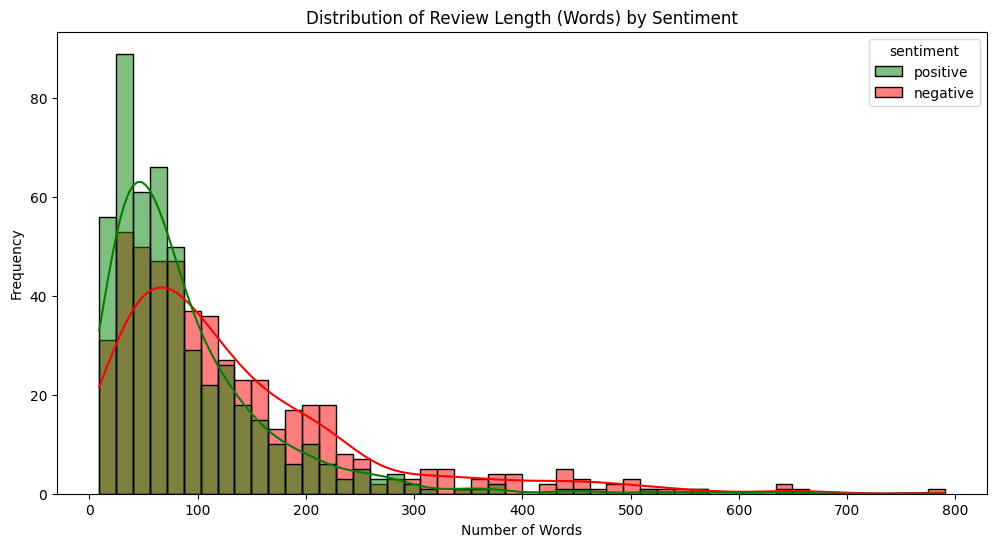

In [ ]:

if 'df' in locals() or 'df' in globals():
    if 'text' in df.columns:
        # Handle potential NaNs or non-string types in 'text' column before length calculation
        df['text'] = df['text'].astype(str) # Convert all to string, NaNs become 'nan'
        df['review_length_chars'] = df['text'].apply(len)
        df['review_length_words'] = df['text'].apply(lambda x: len(x.split()))

        print("Descriptive statistics for review length (characters):")
        print(df['review_length_chars'].describe())
        print("\n" + "="*50 + "\n")

        print("Descriptive statistics for review length (words):")
        print(df['review_length_words'].describe())
        print("\n" + "="*50 + "\n")

        # Plot distribution of review length (characters)
        plt.figure(figsize=(12, 5))
        sns.histplot(df['review_length_chars'], bins=50, kde=True)
        plt.title('Distribution of Review Length (Number of Characters)')
        plt.xlabel('Number of Characters')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--')
        plt.show()
        print("\n" + "="*50 + "\n")

        # Plot distribution of review length (words)
        plt.figure(figsize=(12, 5))
        sns.histplot(df['review_length_words'], bins=50, kde=True)
        plt.title('Distribution of Review Length (Number of Words)')
        plt.xlabel('Number of Words')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--')
        plt.show()
        print("\n" + "="*50 + "\n")

        # Compare review length by sentiment
        if 'sentiment' in df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='sentiment', y='review_length_chars', data=df, palette={'positive': 'green', 'negative': 'red'})
            plt.title('Review Length (Characters) by Sentiment')
            plt.xlabel('Sentiment')
            plt.ylabel('Number of Characters')
            plt.grid(axis='y', linestyle='--')
            plt.show()
            print("\n" + "="*50 + "\n")

            plt.figure(figsize=(12, 6))
            sns.boxplot(x='sentiment', y='review_length_words', data=df, palette={'positive': 'green', 'negative': 'red'})
            plt.title('Review Length (Words) by Sentiment')
            plt.xlabel('Sentiment')
            plt.ylabel('Number of Words')
            plt.grid(axis='y', linestyle='--')
            plt.show()

            # Histograms overlaid for word count by sentiment
            plt.figure(figsize=(12, 6))
            sns.histplot(data=df, x='review_length_words', hue='sentiment', kde=True, bins=50, palette={'positive': 'green', 'negative': 'red'})
            plt.title('Distribution of Review Length (Words) by Sentiment')
            plt.xlabel('Number of Words')
            plt.ylabel('Frequency')
            plt.show()

        else:
            print("'sentiment' column not found for length comparison.")
    else:
        print("'text' column not found in the DataFrame 'df'.")
else:
    print("Error: DataFrame 'df' not found. Please ensure Updated EDA Block 1 was executed successfully.")

## Data Wrangling Utility Functions

In [ ]:
df = balanced_sample_df.copy()

# Map sentiment to numeric labels
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Step 2: Keep only what's needed for BERT
df_bert = df[['text', 'label']].dropna()

# Step 3: Check class balance and text length
print(df_bert['label'].value_counts())
print(df_bert['text'].str.len().describe())


label
1    30000
0    30000
Name: count, dtype: int64
count    60000.000000
mean       600.565033
std        555.377554
min          1.000000
25%        241.000000
50%        431.000000
75%        764.000000
max       5000.000000
Name: text, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.30, random_state=42, shuffle=True
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.50, random_state=42, shuffle=True
)


# Model 1- DistilBERT

In [ ]:
# Step 1: Load DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenize the text data
distilbert_train_encodings = distilbert_tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
distilbert_val_encodings   = distilbert_tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)
distilbert_test_encodings  = distilbert_tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to TensorFlow datasets
def convert_to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels))

# Shuffle size to exact dataset length
shuffle_size = len(train_labels)

distilbert_train_dataset = convert_to_tf_dataset(distilbert_train_encodings, train_labels).shuffle(shuffle_size).batch(16)
distilbert_val_dataset   = convert_to_tf_dataset(distilbert_val_encodings, val_labels).batch(16)
distilbert_test_dataset  = convert_to_tf_dataset(distilbert_test_encodings, test_labels).batch(16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTr

In [ ]:
# Compile the DistilBERT model with a tuned learning rate
distilbert_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
distilbert_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

distilbert_model.compile(
    optimizer=distilbert_optimizer,
    loss=distilbert_loss_fn,
    metrics=["accuracy"]
)

from tf_keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Step 6: Train the DistilBERT model with early stopping
distilbert_history = distilbert_model.fit(
    distilbert_train_dataset,
    validation_data=distilbert_val_dataset,
    epochs=5,
    callbacks=[early_stop]
)


Type of distilbert_optimizer: <class 'tf_keras.src.optimizers.adam.Adam'>
Expected type from tf.keras.optimizers: <class 'tf_keras.src.optimizers.adam.Adam'>
Epoch 1/5
2625/2625 [==============================] - 630s 229ms/step - loss: 0.2530 - accuracy: 0.8956 - val_loss: 0.2239 - val_accuracy: 0.9082
Epoch 2/5
2625/2625 [==============================] - 584s 223ms/step - loss: 0.1668 - accuracy: 0.9348 - val_loss: 0.2354 - val_accuracy: 0.9152


In [ ]:
# Save distilbert model for re-use at a later time
save_path = "/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/distilbert_sentiment_model"

# Save model weights and config
distilbert_model.save_pretrained(save_path)

# Save tokenizer files
distilbert_tokenizer.save_pretrained(save_path)

print(f"✅ DistilBERT model and tokenizer saved to:\n{save_path}")


✅ DistilBERT model and tokenizer saved to:
/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/distilbert_sentiment_model


## Test Loss and Accuracy

In [ ]:
# Evaluate the DistilBERT model on the test dataset
test_loss, test_accuracy = distilbert_model.evaluate(distilbert_test_dataset)
print(f"✅ Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")


563/563 [==============================] - 39s 69ms/step - loss: 0.2236 - accuracy: 0.9104
✅ Test Accuracy: 0.9104 | Test Loss: 0.2236


## Measure Performance

563/563 [==============================] - 40s 68ms/step
🧾 DistilBERT Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.90      0.91      4500
    positive       0.90      0.93      0.92      4500

    accuracy                           0.92      9000
   macro avg       0.92      0.92      0.92      9000
weighted avg       0.92      0.92      0.92      9000



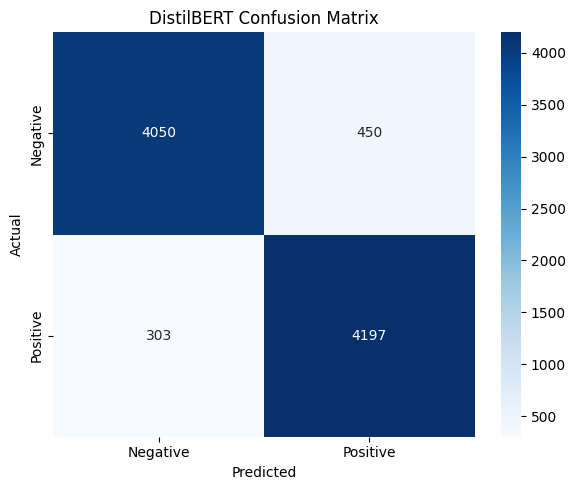

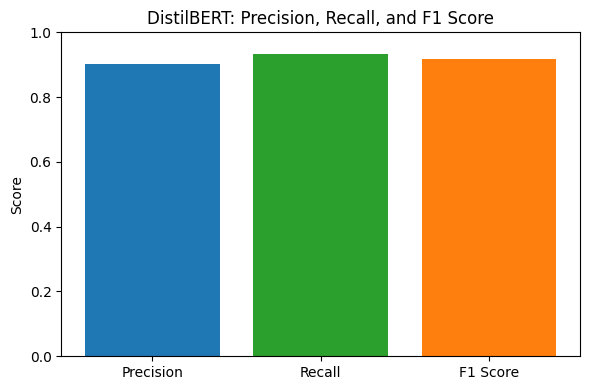

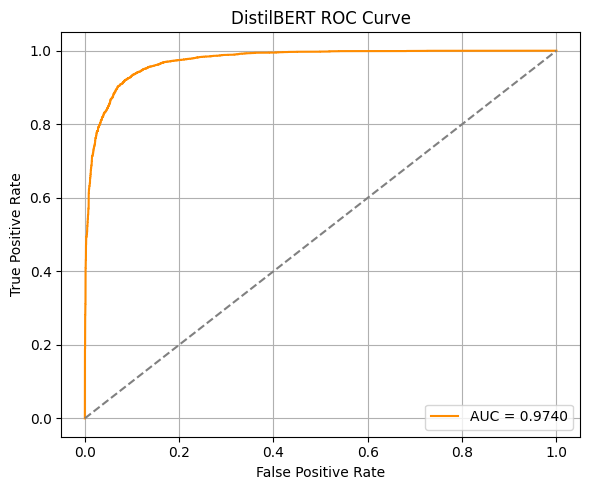

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
import tensorflow as tf

# Step 1: Predict on test set
distilbert_pred_logits = distilbert_model.predict(distilbert_test_dataset).logits
distilbert_y_pred = np.argmax(distilbert_pred_logits, axis=1)
distilbert_y_true = np.array(test_labels)
distilbert_y_probs = tf.nn.softmax(distilbert_pred_logits, axis=1).numpy()[:, 1]

# Step 2: Core metrics
precision = precision_score(distilbert_y_true, distilbert_y_pred)
recall    = recall_score(distilbert_y_true, distilbert_y_pred)
f1        = f1_score(distilbert_y_true, distilbert_y_pred)
auc       = roc_auc_score(distilbert_y_true, distilbert_y_probs)

# Step 3: Classification Report
print("🧾 DistilBERT Classification Report:")
print(classification_report(distilbert_y_true, distilbert_y_pred, target_names=["negative", "positive"]))

# Step 4: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(distilbert_y_true, distilbert_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DistilBERT Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 5: Precision, Recall, F1 Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], [precision, recall, f1], color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.ylim(0, 1)
plt.title('DistilBERT: Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Step 6: ROC Curve
fpr, tpr, thresholds = roc_curve(distilbert_y_true, distilbert_y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DistilBERT ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model 2 - RoBERTa

In [ ]:
import tensorflow as tf
from transformers import (
    RobertaTokenizerFast,
    TFRobertaForSequenceClassification
)
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
roberta_model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Step 2: Tokenize the text data
roberta_train_encodings = roberta_tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
roberta_val_encodings   = roberta_tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)
roberta_test_encodings  = roberta_tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Step 3: Convert to TensorFlow datasets
def convert_to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels))

shuffle_size = len(train_labels)

roberta_train_dataset = convert_to_tf_dataset(roberta_train_encodings, train_labels).shuffle(shuffle_size).batch(16)
roberta_val_dataset   = convert_to_tf_dataset(roberta_val_encodings, val_labels).batch(16)
roberta_test_dataset  = convert_to_tf_dataset(roberta_test_encodings, test_labels).batch(16)

# Step 4: Compile the RoBERTa model
roberta_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
roberta_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

roberta_model.compile(
    optimizer=roberta_optimizer,
    loss=roberta_loss_fn,
    metrics=["accuracy"]
)

# Step 5: Add EarlyStopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Step 6: Train the RoBERTa model
roberta_history = roberta_model.fit(
    roberta_train_dataset,
    validation_data=roberta_val_dataset,
    epochs=5,
    callbacks=[early_stop]
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/5
2625/2625 [==============================] - 1239s 456ms/step - loss: 0.2307 - accuracy: 0.9069 - val_loss: 0.2361 - val_accuracy: 0.9157
Epoch 2/5
2625/2625 [==============================] - 1193s 455ms/step - loss: 0.1701 - accuracy: 0.9335 - val_loss: 0.1969 - val_accuracy: 0.9252
Epoch 3/5
2625/2625 [==============================] - 1188s 453ms/step - loss: 0.1303 - accuracy: 0.9505 - val_loss: 0.2050 - val_accuracy: 0.9219


In [ ]:
# Save roberta model for re-use at a later time
save_path = "/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/roberta_sentiment_model"

# Save model weights and config
roberta_model.save_pretrained(save_path)

# Save tokenizer files
roberta_tokenizer.save_pretrained(save_path)

print(f"✅ RoBERTa model and tokenizer saved to:\n{save_path}")


✅ RoBERTa model and tokenizer saved to:
/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/roberta_sentiment_model


## Test Loss and Accuracy

In [ ]:
# Evaluate the roberta model on the test dataset
test_loss, test_accuracy = roberta_model.evaluate(roberta_test_dataset)
print(f"✅ Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

563/563 [==============================] - 77s 137ms/step - loss: 0.1933 - accuracy: 0.9216
✅ Test Accuracy: 0.9216 | Test Loss: 0.1933


## Measure Performance

563/563 [==============================] - 80s 136ms/step
🧾 RoBERTa Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.90      0.92      4500
    positive       0.91      0.94      0.92      4500

    accuracy                           0.92      9000
   macro avg       0.92      0.92      0.92      9000
weighted avg       0.92      0.92      0.92      9000



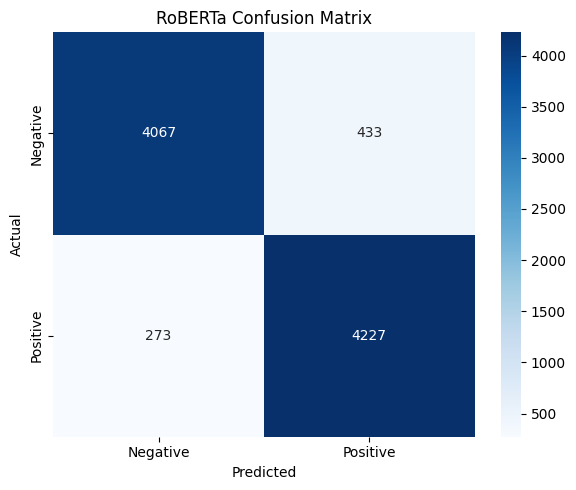

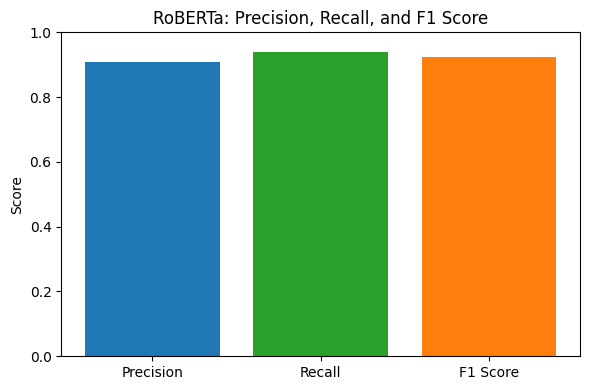

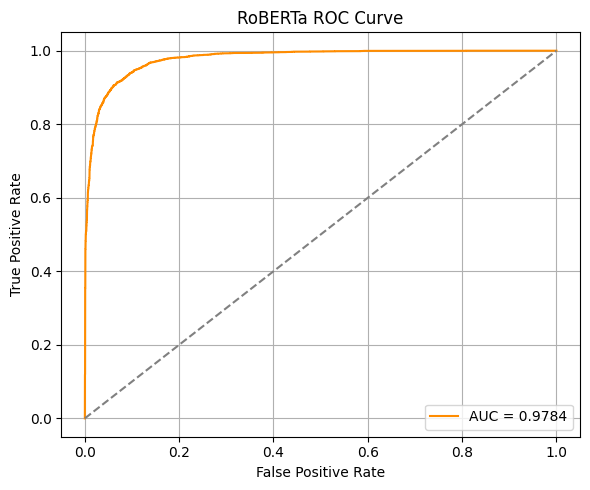

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
import tensorflow as tf

# Step 1: Predict on test set
roberta_pred_logits = roberta_model.predict(roberta_test_dataset).logits
roberta_y_pred = np.argmax(roberta_pred_logits, axis=1)
roberta_y_true = np.array(test_labels)
roberta_y_probs = tf.nn.softmax(roberta_pred_logits, axis=1).numpy()[:, 1]

# Step 2: Core metrics
precision = precision_score(roberta_y_true, roberta_y_pred)
recall    = recall_score(roberta_y_true, roberta_y_pred)
f1        = f1_score(roberta_y_true, roberta_y_pred)
auc       = roc_auc_score(roberta_y_true, roberta_y_probs)

# Step 3: Classification Report
print("🧾 RoBERTa Classification Report:")
print(classification_report(roberta_y_true, roberta_y_pred, target_names=["negative", "positive"]))

# Step 4: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(roberta_y_true, roberta_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RoBERTa Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 5: Precision, Recall, F1 Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], [precision, recall, f1], color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.ylim(0, 1)
plt.title('RoBERTa: Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Step 6: ROC Curve
fpr, tpr, thresholds = roc_curve(roberta_y_true, roberta_y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoBERTa ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## XXX

# Model 3 - DeBERTa v3

In [ ]:
import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification
)
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load DeBERTa v3 tokenizer and model
deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
deberta_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)

# Step 2: Tokenize the text data
deberta_train_encodings = deberta_tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
deberta_val_encodings   = deberta_tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)
deberta_test_encodings  = deberta_tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Step 3: Convert to TensorFlow datasets
def convert_to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels))

shuffle_size = len(train_labels)

deberta_train_dataset = convert_to_tf_dataset(deberta_train_encodings, train_labels).shuffle(shuffle_size).batch(16)
deberta_val_dataset   = convert_to_tf_dataset(deberta_val_encodings, val_labels).batch(16)
deberta_test_dataset  = convert_to_tf_dataset(deberta_test_encodings, test_labels).batch(16)

# Step 4: Compile the DeBERTa model
deberta_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
deberta_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

deberta_model.compile(
    optimizer=deberta_optimizer,
    loss=deberta_loss_fn,
    metrics=["accuracy"]
)

# Step 5: Add EarlyStopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Step 6: Train the DeBERTa model
deberta_history = deberta_model.fit(
    deberta_train_dataset,
    validation_data=deberta_val_dataset,
    epochs=5,
    callbacks=[early_stop]
)


All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler', 'cls_dropout', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
2625/2625 [==============================] - 1999s 741ms/step - loss: 0.2045 - accuracy: 0.9186 - val_loss: 0.2122 - val_accuracy: 0.9234
Epoch 2/5
2625/2625 [==============================] - 1923s 733ms/step - loss: 0.1481 - accuracy: 0.9437 - val_loss: 0.1835 - val_accuracy: 0.9303
Epoch 3/5
2625/2625 [==============================] - 1920s 731ms/step - loss: 0.1075 - accuracy: 0.9601 - val_loss: 0.2055 - val_accuracy: 0.9283


In [ ]:
# Save DeBERTa model for re-use at a later time
save_path = "/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/deberta_sentiment_model"

# Save model weights and config
deberta_model.save_pretrained(save_path)

# Save tokenizer files
deberta_tokenizer.save_pretrained(save_path)

print(f"✅ DeBERTa model and tokenizer saved to:\n{save_path}")


✅ DeBERTa model and tokenizer saved to:
/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/deberta_sentiment_model


## Test Loss and Accuracy

In [ ]:
# Evaluate the DeBERTa model on the test dataset
test_loss, test_accuracy = deberta_model.evaluate(deberta_test_dataset)
print(f"✅ Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")


563/563 [==============================] - 104s 185ms/step - loss: 0.1872 - accuracy: 0.9316
✅ Test Accuracy: 0.9316 | Test Loss: 0.1872


## Measure Performance

563/563 [==============================] - 109s 183ms/step
🧾 DeBERTa Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.94      0.93      4500
    positive       0.94      0.93      0.93      4500

    accuracy                           0.93      9000
   macro avg       0.93      0.93      0.93      9000
weighted avg       0.93      0.93      0.93      9000



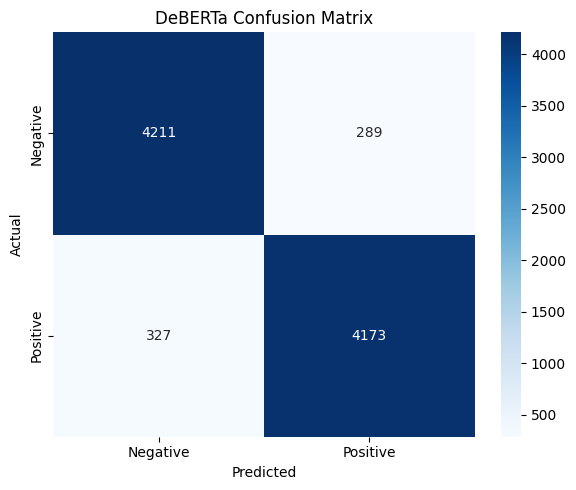

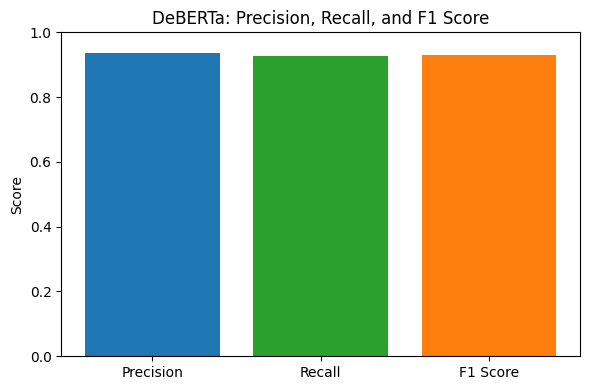

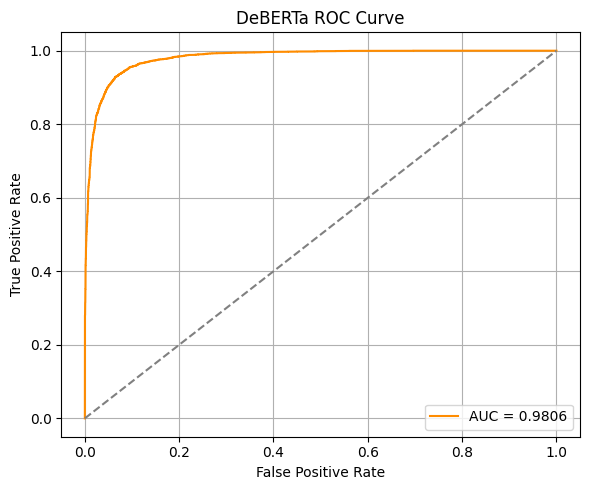

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
import tensorflow as tf

# Step 1: Predict on test set
deberta_pred_logits = deberta_model.predict(deberta_test_dataset).logits
deberta_y_pred = np.argmax(deberta_pred_logits, axis=1)
deberta_y_true = np.array(test_labels)
deberta_y_probs = tf.nn.softmax(deberta_pred_logits, axis=1).numpy()[:, 1]

# Step 2: Core metrics
precision = precision_score(deberta_y_true, deberta_y_pred)
recall    = recall_score(deberta_y_true, deberta_y_pred)
f1        = f1_score(deberta_y_true, deberta_y_pred)
auc       = roc_auc_score(deberta_y_true, deberta_y_probs)

# Step 3: Classification Report
print("🧾 DeBERTa Classification Report:")
print(classification_report(deberta_y_true, deberta_y_pred, target_names=["negative", "positive"]))

# Step 4: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(deberta_y_true, deberta_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DeBERTa Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 5: Precision, Recall, F1 Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], [precision, recall, f1], color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.ylim(0, 1)
plt.title('DeBERTa: Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Step 6: ROC Curve
fpr, tpr, thresholds = roc_curve(deberta_y_true, deberta_y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DeBERTa ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model 4- DistilBERT with Tuning

In [ ]:
# Step 1: Load DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert_tune_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenize the text data
distilbert_train_encodings = distilbert_tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=256)
distilbert_val_encodings   = distilbert_tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=256)
distilbert_test_encodings  = distilbert_tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=256)

# Convert to TensorFlow datasets
def convert_to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels))

# Shuffle size to exact dataset length
shuffle_size = len(train_labels)

distilbert_train_dataset = convert_to_tf_dataset(distilbert_train_encodings, train_labels).shuffle(shuffle_size).batch(8)
distilbert_val_dataset   = convert_to_tf_dataset(distilbert_val_encodings, val_labels).batch(8)
distilbert_test_dataset  = convert_to_tf_dataset(distilbert_test_encodings, test_labels).batch(8)

# Compile the DistilBERT model with a tuned learning rate
distilbert_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
distilbert_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

distilbert_tune_model.compile(
    optimizer=distilbert_optimizer, # Pass the optimizer instance directly
    loss=distilbert_loss_fn,
    metrics=["accuracy"]
)

from tf_keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Step 6: Train the DistilBERT model with early stopping
distilbert_history = distilbert_tune_model.fit(
    distilbert_train_dataset,
    validation_data=distilbert_val_dataset,
    epochs=5,
    callbacks=[early_stop]
)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
5250/5250 [==============================] - 1273s 238ms/step - loss: 0.2304 - accuracy: 0.9067 - val_loss: 0.2043 - val_accuracy: 0.9184
Epoch 2/5
5250/5250 [==============================] - 1217s 232ms/step - loss: 0.1515 - accuracy: 0.9414 - val_loss: 0.1895 - val_accuracy: 0.9218
Epoch 3/5
5250/5250 [==============================] - 1215s 231ms/step - loss: 0.0923 - accuracy: 0.9655 - val_loss: 0.2450 - val_accuracy: 0.9209


In [ ]:
# Save path for DistilBERT tune model
save_path = "/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/distilbert_tune_sentiment_model"

# Save model weights and config
distilbert_tune_model.save_pretrained(save_path)

# Save tokenizer files
distilbert_tokenizer.save_pretrained(save_path)

print(f"✅ Distilbert tune model and tokenizer saved to:\n{save_path}")


✅ Distilbert tune model and tokenizer saved to:
/content/gdrive/MyDrive/Colab Notebooks/NLP_Assignments/distilbert_tune_sentiment_model


## Test Loss and Accuracy

In [ ]:
# Evaluate the tuned DistilBERT model (best_model) on the test dataset
test_loss, test_accuracy = distilbert_tune_model.evaluate(distilbert_test_dataset)
print(f"✅ Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

1125/1125 [==============================] - 86s 76ms/step - loss: 0.1887 - accuracy: 0.9250
✅ Test Accuracy: 0.9250 | Test Loss: 0.1887


## Measure Performance

1125/1125 [==============================] - 86s 75ms/step
🧾 DistilBERT Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.94      0.93      4464
    positive       0.94      0.91      0.92      4536

    accuracy                           0.93      9000
   macro avg       0.93      0.93      0.92      9000
weighted avg       0.93      0.93      0.92      9000



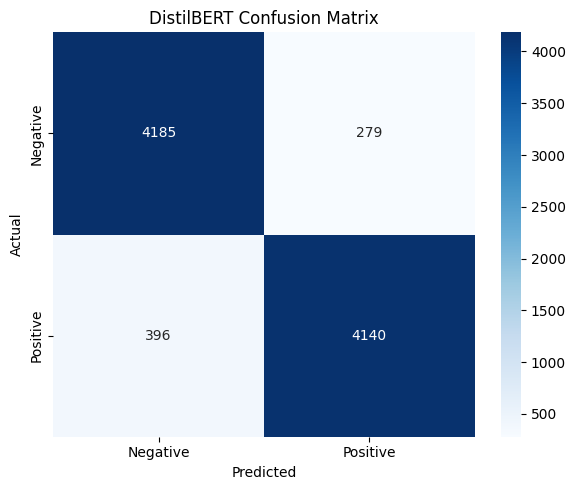

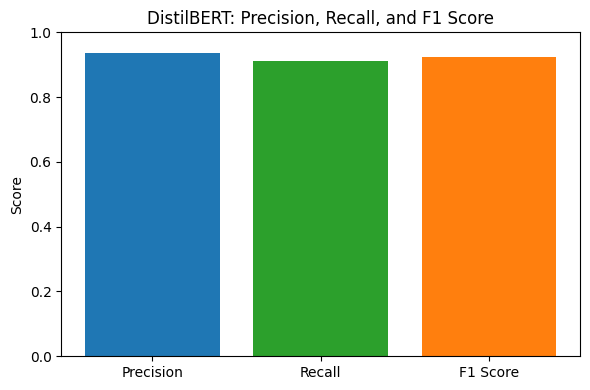

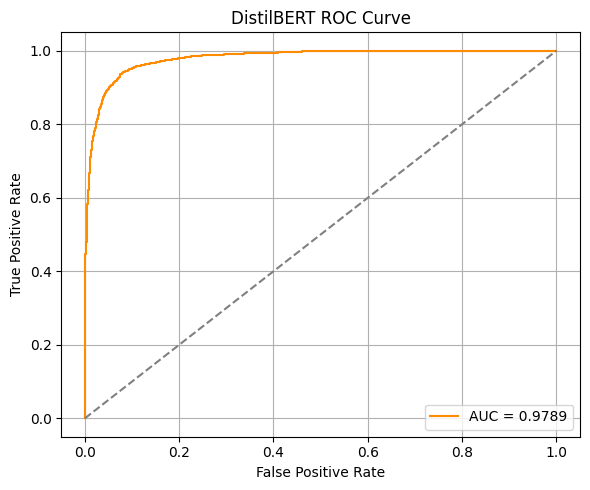

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
import numpy as np # Assuming np is used for np.argmax and np.array
import tensorflow as tf # Assuming tf is used for tf.nn.softmax
import matplotlib.pyplot as plt # Assuming plt is used for plotting
import seaborn as sns # Assuming sns is used for heatmap

# Step 1: Predict on test set
# Ensure 'distilbert_tune_model' and 'distilbert_test_dataset' are defined elsewhere in your code
# Ensure 'test_labels' is also defined
distilbert_pred_logits = distilbert_tune_model.predict(distilbert_test_dataset).logits
distilbert_y_pred = np.argmax(distilbert_pred_logits, axis=1)
distilbert_y_true = np.array(test_labels) # Make sure test_labels is defined
distilbert_y_probs = tf.nn.softmax(distilbert_pred_logits, axis=1).numpy()[:, 1]

# Step 2: Core metrics
precision = precision_score(distilbert_y_true, distilbert_y_pred)
recall    = recall_score(distilbert_y_true, distilbert_y_pred)
f1        = f1_score(distilbert_y_true, distilbert_y_pred)
auc       = roc_auc_score(distilbert_y_true, distilbert_y_probs)

# Step 3: Classification Report
print("🧾 DistilBERT Classification Report:")
print(classification_report(distilbert_y_true, distilbert_y_pred, target_names=["negative", "positive"]))

# Step 4: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(distilbert_y_true, distilbert_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DistilBERT Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 5: Precision, Recall, F1 Score Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], [precision, recall, f1],
        color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.ylim(0, 1)
plt.title('DistilBERT: Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Step 6: ROC Curve
fpr, tpr, thresholds = roc_curve(distilbert_y_true, distilbert_y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DistilBERT ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()